# Brief Introduction to Relationship Attributes

<ol>
<li><a href='#Basic-Setup'>Basic Setup</a></li>

<li><a href='#Overview'>Overview</a>
<ol>
<li><a href='#Creating-a-Relationship:-Step-by-Step'>Creating a Relationship: Step-by-Step</a>
<ul>
<li><a href='#Specifing-the-target-via-a-RelationshipTargetSpec'>Specifing the target via a RelationshipTargetSpec</a></li>
<li><a href='#Specifing-a-relationship-via-a-RelationshipSpec'>Specifing a relationship via a RelationshipSpec</a></li>
<li><a href='#Saving-a-relationship-via-a-RelationshipAttribute'>Saving a relationship via a RelationshipAttribute</a></li>
</ul></li>
<li><a href='#Creating-a-Relationship:-The-Shortcut'>Creating a Relationship: The Shortcut</a></li>
<li><a href='#Using-Relationships'>Using Relationships</a>
<ul><li><a href='#Relationship-Slicing'>Relationship Slicing</a></li></ul>
</li>
</ol>
</li>

<li><a href='#Type-of-relationships-and-their-uses'>Types of relationships and their uses</a>
<ol>
<li><a href='#Order'>`Order`</a></li>
<li><a href='#Equivilant'>`Equivilant`</a></li>
<li><a href='#Shared-Encoding'>`Shared Ordered Encoding`</a></li>
<li><a href='#Shared-Ascending-Encoding'>`Shared Ascending Encoding`</a></li>
<li><a href='#Indexes'>`Indexes`</a></li>
<li><a href='#Indexes-Values'>`Indexes Values`</a></li>
</ol>
</li>

<li><a href='#Relationship-Chains'>Relationship Chains</a>
<ol>
<li><a href='#Index-Map-Relationships'>Index Map Relationships</a>
<ul>
<li><a href='#Creating-Index-Map-Relationships'>Creating Index Map Relationships</a>
<ul>
<li><a href='#Create-two-example-image-datasets'>Create two example image datasets</a>
<li><a href='#Create-the-mappings-between-image1-and-image2'>Create the mappings between `image1` and `image2`</a>
<li><a href='#Creating-the-Index-Map-Relationship-for-our-Example-Image-Data'>Creating the Index Map Relationship for our Example Image Data</a>
</ul>
</li>
<li><a href='#Interacting-with-Index-Map-Relationships'>Interacting with Index Map Relationships</a>
<ul>
<li><a href='#Retrieving-Index-Map-Relationships'>Retrieving Index Map Relationships</a></li>
<li><a href='#Using-Index-Map-Relationships-to-Locate-the-Source,-Target,-and-Map'>Using Index Map Relationships to Locate the Source, Target, and Map</a></li>
<li><a href='#Using-Index-Map-Relationships-to-Load-Data'>Using Index Map Relationships to Load Data</a></li>
<li><a href='#Summary:-Interacting-with-Index-Map-Relationships'>Summary: Interacting with Index Map Relationships</a></li>
</ul>
</li>
</ul>
</li>
<li><a href='#Other-Relationship-Chains'>Other Relationship Chains</a></li>
</ol>
</li>

</ol>



# Basic Setup

This section contains code for the basic setup of this tutorial.

In [1]:
# Import basic packages needed for this notebook
import sys
import numpy as np
from scipy.ndimage import zoom as image_zoom
import h5py
from IPython.display import Image 
from tempfile import NamedTemporaryFile
try:
    %matplotlib inline
    import matplotlib
    import matplotlib.pyplot as plt
    HAS_PLT = True
except:
    HAS_PLT = False

# If the brain module is not installed in your default path then set the path to it, e.g., via
# sys.path.append("...")

# Import the classes related to the management of relationships
from brain.dataformat.spec import RelationshipTargetSpec, RelationshipSpec, BaseSpec
from brain.dataformat.base import RelationshipAttribute

In [2]:
# Create a temporaryr HDF5 file for testing
tempfile = NamedTemporaryFile()
test_file = h5py.File(tempfile.name, 'a')

In [3]:
# Create some simple example datasets in our temporary file for testing
test_file['t1'] = np.arange(10)
test_file['t2'] = np.arange(10) + 10
test_file['t3'] = np.arange(10) + 5.1
test_file['t2d_1'] = np.arange(100).reshape((10,10))
test_file['t2d_2'] = np.arange(100).reshape((10,10)) + 10
# Assign the datasets to variables
t1 = test_file['t1']
t2 = test_file['t2']
t3 = test_file['t3']
t2d_1 = test_file['t2d_1']
t2d_2 = test_file['t2d_2']

<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

# Overview

The concept of relationships is effectively describes an extension of the HDF5 primitives to enable us to describe relationships between objects (i.e., Groups and Datasets) in HDF5 files. 

<u>**Specification**</u> Relationships are described in Python via JSON serializable dictionaries that describe the `source`, `target`,  `type`, `description`, and storage properties of the relationship (see below for details). The BRAINformat library provides the following main classes to help with the specification of relationships:

* **`RelationshipTargetSpec` :** Define a dictionary describing the `target` of the relationship
* **`RelationshipSpec` :** Define a dictionary with the complete specification of the relationship

<u>**Storage**</u> Relationships are described via a formal specification and stored in HDF5 as attributes.  The BRAIN library prepends `RELATIONSHIP_ATTR` to the attribute name help with the identification of attributes that define relationships. The specification of relationships is typically stored as a JSON string in HDF5. The use of JSON is primarily a choice of convenience. Alternatively, one could also use an HDF5 compound dataset to store relationship specifications. While the use of a compound dataset has advantages---mainly that it relies only on HDF5 primitives---and is not hard to do in Python, the use of changing compound datatypes can be tricky in other (typed) languages. The BRAINformat library provides the following main classes to help with the interaction with relationships stored in HDF5:

* **`RelationshipAttribute` :** Store, retrieve, and resolve relationships described in HDF5

## Creating a new RelationshipAttribute

In this example we will create a relationship between t1 and t2 that says that the objects in t1 are ordered the same way as the objects in t2. 

A relationship consists of a source, target, and definition of the relationship. The source of a relationship is defined simply by the dataset (or group) that the Relationship Attribute (that describes the relationship) is assigned to. We may define an optional `axis` to describe, which dimension the relationship is associated with. 

The target is defined via a `RelationshipTargetSpec` specification, describing how we can get from the source to the target object. 

The actual function of the relationship is then mainly defined by the relationship type.

### Creating a Relationship: Step-by-Step

#### Specifing the target via a RelationshipTargetSpec

First, we need to create is a description of the target we are pointing to, i.e., how do we get from `t1` to `t2`. Since we know `t1` and `t2`, we can use the convenient function `from_objects(...)` provided by the `RelationshipTargetSpec` class to easily create this description.

In [4]:
target_spec_t1_to_t2 = RelationshipTargetSpec.from_objects(source_object=t1, 
                                                           target_object=t2)

Let's see what the description of the target specification looks like. Since RelationshipTargetSpec inherits from BaseSpec we can easily convert the specificaiton to/from JSON.

In [5]:
print target_spec_t1_to_t2.to_json(pretty=True)

{
    "axis": null,
    "dataset": "t2",
    "filename": null,
    "global_path": null,
    "group": null,
    "prefix": null,
    "prefix_all": null
}


`t2` and `t1` are both located in the same parent group so the description simply contains the name of `t2`. We could have naturally also created the same specification ourselves via `RelationshipTargetSpec(dataset='t2', group=None, prefix=None)` but if we know the HDF5 objects we want to relate, then using `from_objects(...)` is usally simpler. 

#### Specifing a relationship via a RelationshipSpec

Second, now that we have a description of our target we can go ahead and specify our relationship.

In [6]:
rel_spec_t1_to_t2 = RelationshipSpec(attribute='rel_t2',  # Name of the attribute we want to use to store the relationship
                                     target=target_spec_t1_to_t2,  # The specification of our target
                                     relationship_type='order',    # How are the datasets related with each other
                                     description='Test relationship')  # Human-readable description of the relationship

#### Saving a relationship via a RelationshipAttribute

Finally, we need to save our relationship to file by creating a new RelationshipAttribute. As usual, we provide a create function for this purpose. 

In [7]:
rel1 = RelationshipAttribute.create(parent_object=t1,  # The source of the relationship
                                    relationship=rel_spec_t1_to_t2)  # The specification of our relationship

To confirm that we indeed now have a new attribute on `t1`, let's have a look at all attributes:

In [8]:
for attr_name, attr_value in t1.attrs.iteritems():
    print (attr_name, attr_value)

(u'RELATIONSHIP_ATTR_rel_t2', '{"target": {"group": null, "global_path": null, "dataset": "t2", "prefix": null, "prefix_all": null, "filename": null, "axis": null}, "attribute": "rel_t2", "description": "Test relationship", "prefix": null, "relationship_type": "order", "optional": false, "properties": null, "axis": null}')


As we can see, we now have a new relationship attribute. The BRAIN library prepended the `RELATIONSHIP_ATTR` to help with the identification of attributes that define relationships. The descriptions is typically stored as JSON. One could also use an HDF5 compound dataset to describe a relationship. While the use of a compound dataset has many advantages---we stay in HDF5, more compact etc.---and is not hard to do in Python, the use of changing compound datatypes can be tricky in other languages.

<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

### Creating a Relationship: The Shortcut

Instead of constructing the specification of the target and the relationship and then crating the `RelationshipAttribute`, we can use the `RelationshipAttribute.create(...)` function to conveniently create everything in one shot:

In [9]:
rel_temp = RelationshipAttribute.create(parent_object=t1,
                                        target_object=t2,
                                        attribute='rel_temp_to_t2',
                                        relationship_type='order',
                                        description='Test relationship to show creation of relationships')
print rel_temp.relationship_spec.to_json(pretty=True)  # Print the relationship for validation purposes only

{
    "attribute": "rel_temp_to_t2",
    "axis": null,
    "description": "Test relationship to show creation of relationships",
    "optional": false,
    "prefix": null,
    "properties": null,
    "relationship_type": "order",
    "target": {
        "axis": null,
        "dataset": "t2",
        "filename": null,
        "global_path": null,
        "group": null,
        "prefix": null,
        "prefix_all": null
    }
}


<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

## Using Relationships

We can use the RelationshipAttribute class (and instances thereof) to directly interact with relationships.

In [10]:
source = rel1.source             # Getting the source of the relationship (here, t1)
source_axis = rel1.source_axis   # Getting the axis to which the relationship applies
target = rel1.target             # Getting the target of the relationship (here, t2)
target_axis = rel1.target_axis   # Getting the axis on the target to which the relationship applies
rtype = rel1.relationship_type   # Getting the type of the relationship
rspec = rel1.relationship_spec   # Getting the sepcification of the relationship as a RelationshipSpec
tspec = rel1.target_spec         # Getting the sepcification of the target as a RelationshipTargetSpec 
                                 # Alternatively we could also get the target specification from our RelationshipSpec
                                 # >>>  tspec = rspec['target'] 
                                 
print "(Source, Axis) = (" + str(source) + ", " + str(source_axis) + ")"  
print "(Target, Axis) = (" + str(target) + ", " + str(target_axis) + ")"
print "Relationship Type = " + str(rtype)
# We here use to_json(True) only to achieve a nice print
print "Relationship Specification " + rspec.to_json(pretty=True)    

(Source, Axis) = (<HDF5 dataset "t1": shape (10,), type "<i8">, None)
(Target, Axis) = (<HDF5 dataset "t2": shape (10,), type "<i8">, None)
Relationship Type = order
Relationship Specification {
    "attribute": "rel_t2",
    "axis": null,
    "description": "Test relationship",
    "optional": false,
    "prefix": null,
    "properties": null,
    "relationship_type": "order",
    "target": {
        "axis": null,
        "dataset": "t2",
        "filename": null,
        "global_path": null,
        "group": null,
        "prefix": null,
        "prefix_all": null
    }
}


### Relationship Slicing

For many standard relationship types, the `RelationshipAttribute` API also supports slicing to map selections defined on the `source` to the `target`. The `RelationshipAttribute` API maps the selection but it is up to the user to apply the selection to the `target` to load data if desired. When loading data from the the `target` we need to consider the `target_axis` if set.

In [11]:
 # Loading data from the source of the relationship, i.e., t1
temp_data = rel1.source[0:3]  
print "Loading t1[0:3]: " + str(temp_data)

# We can map slicing operations from the source to the target by slicing into the relationship
temp_data = rel1[0:3]         
print "Mapping [0:3] to the target: " + str(temp_data)

# We can now use the mapped slice to directly access data in the target, i.e., t2
temp_data = rel1.target[rel1[0:3]]  
print "Loading t2[0:3] via the relationship: " + str(temp_data)

Loading t1[0:3]: [0 1 2]
Mapping [0:3] to the target: slice(0, 3, None)
Loading t2[0:3] via the relationship: [10 11 12]


<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

# Types of relationships and their uses

## `Order`

<u>**Type:**</u> `order`

<u>**Description:**</u>

<u>**Typical use case:**</u>

<u>**Slicing:**</u> `order` selections datasets can be directly mapped between two datasets without the need for complex data processing, i.e., the selection given for the `source` is identical to what we need to do for the `target`. The `RelationshipAttribute` API supports this mapping directly. `order` relationship are usually used between datasets since objects in a Group (i.e., HDF5 group) don't have a predefined order. The `RelationshipAttribute` API supports `order` relationships between Groups by assuming that keys in the groups are sorted alphabetically and maps selections (typically names of objects or indexe/slices into the ordered list of keys) acccording. The `RelationshipAttribute` API currently does not support mapping `order` selections between datasets and groups (which are expected to be not very common).

<u>**Example**</u>

See example above

<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

## `Equivilant`

<u>**Type:**</u> `equivalent`

<u>**Description:**</u> In addition to order, this relationship type expresses that the source and target object encode the same data (even if they might store different values). This relationship also implies that the source and target contain the same number of values ordered in the same fashion.

<u>**Typical use case:**</u> Any time the same data is stored multiple times with different encodings, e.g., a user may store a dataset of strings with the names of tokens and store another dataset with the integer ID of the tokens. This is often useful to ease data processing, e.g., while IDs may be better suited for data processing, string names may be better suited for human interpretation.

<u>**Slicing:**</u> Same as for `order`.

<u>**Example**</u>
See `order` example above

<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

## `Shared Encoding`

<u>**Type:**</u> `shared_encoding`

<u>**Description:**</u> The `target` and `source` contain values with the same encoding, i.e., values can be directly compared. The specification of a `target_axis` usually does not make sense for this type of relationship as this relationship refers directly to the values of datasets not their axes. 

<u>**Typical use case:**</u> Generally any time two objects (datasets or groups) contain data with the same encoding, i.e., values or names that can be directly compared via `==` (and `<` , `>` in the case of datasets). Imaging, e.g, the case where we have two datasets with dimension scales that demark regions where a patient performed a particular task. 

<u>**Slicing:**</u> The `RelationshipAttribute` API supports slicing for `shared_encoding` relationships as follows. We assume that we want to locate the same values int `target` as in the `source`. As such we will load the requested data from the `source` and then locate all values in `target` that are equal to at least one of the loaded values.

<u>**Example:**</u> In the below example we create an example `shared encoding` relationship between the 1D dataset `t1` and the 2D dataset `t2d_1`. As we can see the slice defined on the source is translated to a boolean map indicating the corresponding values in the `target` dataset.

In [12]:
rel_se_1 = RelationshipAttribute.create(parent_object=t1,     
                                        target_object=t2d_1,
                                        attribute='rel_t2d_1',
                                        relationship_type='shared_encoding',    
                                        description='test relationship')

Selected data in the source dataset: [1 2 3 4 5 6 7 8]
Selected data in the target dataset: [1 2 3 4 5 6 7 8]
Mapping the selection [1:9] from the 1D source to the 2D target


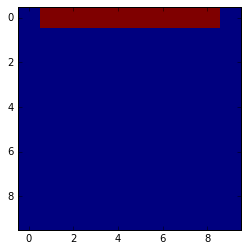

In [13]:
print 'Selected data in the source dataset: ' + str(rel_se_1.source[1:9])
mapped_selection = rel_se_1[1:9] 
print 'Selected data in the target dataset: ' + str(rel_se_1.target[mapped_selection])
print 'Mapping the selection [1:9] from the 1D source to the 2D target'
if HAS_PLT:
    plt.imshow(mapped_selection, interpolation='nearest')
else:
    print mapped_selection

<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

## `Shared Ascending Encoding`

<u>**Type:**</u> `shared_ascending_encoding`

<u>**Description:**</u> The `target` and `source` contain values with the same encoding, i.e., values in the two datasetscan be directly compared. In addition, values are expected to be in ascending order. An example would be a 1D time dimension for two different datasets that are synchronized to a global clock. The specification of a `target_axis` usually does not make sense for this type of relationship as this relationship refers directly to the values of datasets not their axes. 

<u>**Typical use case:**</u>  Relate ordered dimensions, e.g., time axis

<u>**Slicing:**</u> The `RelationshipAttribute` API supports slicing for `shared_ascending_encoding` as follows:
    
1. In the general case, the shared_ascending_encoding behaves exactly like the the shared_encoding
2. In the special case, however, where i) the source and target are 1D datasets and ii) a pure range selection is performed (i.e., a single slice with just a start and stop but no step) the range of the slice is mapped from the source to the target (rather than equals). This is useful, e.g., in the case where we have a time axis and we want to locate a time-frame rather than exact matching values between two datasets. NOTE: If we want to ensure that behavior 1. is always used, then we can simply define a step for slice, i.e., instead of [0:10] we can instead write [0:10:1].

<u>**Example:**</u> 

In [14]:
# Here we are creating a new relationship between t1 and t3 with the type shared_ascending_encoding
rel2 = RelationshipAttribute.create(parent_object=t1,     
                                    target_object=t3,
                                    attribute='rel_t3',
                                    relationship_type='shared_ascending_encoding',    
                                    description='Test relationship')

In [15]:
# We next here show how we can use the relationship to slice into the data
print "Source data all: " + str(rel2.source[:])
print "Target data all: " + str(rel2.target[:])
print "Source selecton: " + str(np.s_[2:9])
print "Selected source data: " + str(rel2.source[2:9])
print "Mapped seleciton: " + str(rel2[2:9])
print "Selected target data: " + str(rel2.target[rel2[2:9]])

Source data all: [0 1 2 3 4 5 6 7 8 9]
Target data all: [  5.1   6.1   7.1   8.1   9.1  10.1  11.1  12.1  13.1  14.1]
Source selecton: slice(2, 9, None)
Selected source data: [2 3 4 5 6 7 8]
Mapped seleciton: slice(0, 3, None)
Selected target data: [ 5.1  6.1  7.1]


In the above example we selected the range `[2:9]` from dataset `t1` (i.e. the source), which are the values `[2 3 4 5 6 7 8]`. The target dataset t3, however, contains only the values `[5.1 6.1 7.1 8.1 9.1 10.1 11.1 12.1 13.1  14.1]`. When mapping the value range (2 to 8) to the target we, hence, retrieve less values, specifically `[5.1  6.1  7.1]`. 

As mentioned above, we can force to use an equals comparison when mapping the selection by defining the step parameter of the slice, which in this case will result in no values being selected as none of the values match exactly:

In [16]:
# Now lets see what happens if don't sl
mapped_selection = rel2[2:9:1]
print "Mapped selection (using equals): " + str(mapped_selection)
print "Total values selected in target: " + str(mapped_selection.sum())

Mapped selection (using equals): [False False False False False False False False False False]
Total values selected in target: 0


<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

## `Indexes`

<u>**Type:**</u> `indexes`

<u>**Description:**</u> The source dataset contains indices into the `target` dataset. These are often integer indices, however, e.g, if the relationship points to a Group, then the `source` dataset may also contain strings selecting the objects stored in the `Group`. The source of such a relationship, however, should always be a dataset. 

<u>**Typical use case:**</u> A typical use is to describe basic data structures, e.g., we may store a list of unique tokens and a larger array that stores integer indicies into the list of tokens.

<u>**Slicing:**</u> The `RelationshipAttribute` API maps slicing operations by retrieving the indices from the source dataset and returing a list of the indicies. NOTE: in case that the `target` is a Group, we may need to iterate over the returned selection as h5py.Group objects do not support simultaneous selection of multiple objects.

<u>**1D Example**</u>

In [17]:
# First, let's create some new datasets 
test_file['token_names'] = np.asarray(['aah', 'bee', 'cat', 'bat', 'fat'])
test_file['token_ids'] = np.random.randint(0, 5, 20)   # Indicies into the token_names array
token_names = test_file['token_names']
token_ids = test_file['token_ids']

In [18]:
# Here just a quick example of how one would use this sort of strucutre in practice 
print "Token IDs: " + str(token_ids[:])
print "Mapped Token IDs: " + str(token_names[:][token_ids[:]])

Token IDs: [2 0 0 2 1 2 0 2 0 0 3 0 2 2 1 4 1 4 2 2]
Mapped Token IDs: ['cat' 'aah' 'aah' 'cat' 'bee' 'cat' 'aah' 'cat' 'aah' 'aah' 'bat' 'aah'
 'cat' 'cat' 'bee' 'fat' 'bee' 'fat' 'cat' 'cat']


In [19]:
# To make the relationship between the datasets explicit we create a RelationshipAttribute
rel_i_1 = RelationshipAttribute.create(parent_object=token_ids,     
                                       target_object=token_names,
                                       attribute='rel_index_target',
                                       relationship_type='indexes',    
                                       description='Relationship describing that token_ids indexes token_names')

In [20]:
# Now we can use the relationship to transparently perform the mapping from the token_ids arrays to the
# token_names without having to know the datasets
target_data = rel_i_1.target[:]     # Here we load the target data into memory because h5py.Dataset does not 
                                    # slicing with out of order lists of indices but numpy does
print target_data[rel_i_1[10:20]]

['bat' 'aah' 'cat' 'cat' 'bee' 'fat' 'bee' 'fat' 'cat' 'cat']


<u>**Exampled: 2D**</u>

In [21]:
# In this example we will show how we can do something similar but where the target is a multi-dimensional array
test_file['matrix_data'] = np.arange(100).reshape(10,10)
temp_index = np.random.randint(0, 5, size=(2,20))
test_file['matrix_index'] = temp_index   # Indicies into the matrix_data dateaset 
matrix_data = test_file['matrix_data']
matrix_index = test_file['matrix_index']

In [22]:
# To make the relationship between the datasets explicit we create a RelationshipAttribute
rel_i_2 = RelationshipAttribute.create(parent_object=matrix_index,     
                                       target_object=matrix_data,
                                       attribute='rel_index_target_2D',
                                       relationship_type='indexes',    
                                       axis=0, 
                                       description='Relationship describing that matrix_index indexes matrix_data')

Alternatively we could also set to:

`axis={'INDEXING_AXIS':0, 'STACK_AXIS':None}`

instead of `axis=0`. In either case the above indicates that we have multi-dimensional indicies where the first dimenions is used to store the two-dimenionsal indicies, while the remaining dimenions are the intrinsic dimenions of the matrix_index dataset itself (whatever they may be).

In [23]:
# Mapping the selection from matrix_index to the matrix_data
mapped_selection = rel_i_2[1:10]
# Printing the resulats of the mapping
print "Mapped Selection: (shape=" + str(mapped_selection.shape) + ")"
print mapped_selection
# Applying the multi-dimensional selection
selected_matrix_data = matrix_data[:][ mapped_selection[0,:] , mapped_selection[1,:] ]
# h5py.Dataset does not support complex multi-dimensional selection but numpy does.
# For convenience we here load the full matrix_data[:] first and then apply the selection
# but we could also iterate over the selection to load one element at-a-time.
print "Selected Data:"
print selected_matrix_data

Mapped Selection: (shape=(2, 9))
[[1 1 0 0 1 0 1 3 2]
 [3 4 4 0 1 4 4 4 3]]
Selected Data:
[13 14  4  0 11  4 14 34 23]


In the above example we used an index dataset `temp_index` of shape `(2,20)`, i.e, we ordered the indicies we select along the 2nd (i.e., last dimension). Depending on preference we may also order selections along the first dimension, in which case the data load would have changed to:

`selected_matrix_data = matrix_data[:][ mapped_selection[`<font color='red'>**...,**</font> ` 0] , mapped_selection[`<font color='red'>**...,**</font> ` 1] ]`

We can determine which notation we need to use by looking at the value of `rel_i_2.source_axis`, which in the above example is `0` --- i.e., `rel_i_2.source_axis` identifies the first axis of the source dataset as the axis that describes the components of the indices, which we can easily check: 


In [24]:
rel_i_2.source_axis == 0

True

<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

## `Indexes Values`

<u>**Type:**</u> `indexes_values`

<u>**Description:**</u> The `source` selects certain parts of the `target` based on the values (or keys in case of group(s)) in the `target`. Specification of an axis for the `target` usually does not make sense for this type of relationship. The `indexes_values` relationship implies that the datasets use a `shared_encoding` (see above) and is effectively a special type of `shared_encoding` relationship that beyond the encoding describes that the `source` is selecting data in the `target` based on value.

<u>**Typical use case:**</u> Value-based referencing of data

<u>**Slicing:**</u> The `RelationshipAttribute` API supports slicing for `indexes_values` relationships as follows: 

- **Source/Target are datasets:** Map the given `selection` via: **`target[:] == self.source[selection]`**
- **Source is dataset and target is group:** Retrieve the selected keys from the source via: **`self.source[source_selection]`**
- **Source/Target arge groups:** Both groups contain objects (groups/datasets) with the same names. The mapping of a given `selection` is, hence, trivial and is the **`selection`** itself.
- **Source is group and target is dataset:** Map the given selection via: **`self.target[:] == selection`**

<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

# Relationship Chains

Describing relationships between individual objects can be used as a tool to describe more complex relationships between data objects, e.g., relationships that are based on complex mappings between data objects. In practice we can describe such relationships via a chain of relationships. A common type of such a complex chain relationship are what we here refer to as **index map relationships**. 

<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

## Index Map Relationships 

Lets look at the following example. Imagine we have taken two different images `A` and `B` of a particualr brain at different resolutions or even from different imaging modalities. We now want to analyze our two images in context of each other. This mean when accessing a set of pixels in image `A` we now want to access the corresponding pixels in image `B` (and vice versa). This seamingly simple task, however, is in practice highly complex. Even if our images are perfectly aligned, a user still has to know exactly: i) how the two datasets are related, ii) how to utilize the information from the registration process to map between `A` and `B`, and iii) write complex code to access the data. 

Using relationships we can i) make this process explicit by describing the relationship between `A` and `B` and ii) greatly simplify the process for interacting with the data. Rather than describing the relationship between `A` and `B` directly we can create a map dataset `map_A_to_B`, which stores for each pixel of `A` the corresponding `(x,y)` pixel index in `B`. Accordingly we can also create a corresponding map `map_B_to_A` to model the reverse relationship between `B` and `A`. These maps explicitly describe the relationship between our images `A` and `B` so that a user can directly utilize the mappings without having to perform complex and error-prone index transformation (which would be needed if we described the mapping via scaling, rotation, morphing and other data transformation). 

Using `RelationshipAttributes` we can describe this complex relatioship between our images as follows:

* **Mapping between `A` and `B`**
     
```
     A <----order---- map_A_to_B ----indexes----> B
      \                 /
       \-----order---->/  
```
       
* **Mapping between `B` and `A`**
     
```
     A <----indexes---- map_B_to_A ----order----> B
                               \                 /
                                \<----order-----/  
```
     
Here, `A, B, map_A_to_B, map_B_to_A` are datasets and `<--, -->` describe `RelationshipAttributes` of the indicated type. In practice one would often also add a `user` relationship between `A` and `B` to document the specific semantic relationship between the two datasets, e.g:


```
     A <----order---- map_A_to_B ----indexes----> B
      \                 /                        /
       \-----order---->/                        /
        \                                      /
         \---------------user---------------->/

```

While index map relationships may seem complicated, the BRAINformat API provides a series of convient functions, which greatly simplify the us of these kinds of index map relationships in practice; in particular:

* **`RelationshipAttribute.create_index_map_relationship(...)`** conveniently creates for us all relationship required to define the index map relationshiph
* **`RelationshipAttribute.get_index_map_relationship_names(...)`** generates a list of all unique names of index map relationshipsh
* **`RelationshipAttribute.get_index_map_relationship(...)`** retrieves all relationships that belong to a particular index map relationship. 
* **`RelationshipAttribute.INDEX_MAP_RELATIONSHIP_POSTFIX`** Is a python dictionary describing the standard postfixs used to identify the four relationships used to model the index to map relationship, i.e., the mandatory `MAP_TO_TARGET`, `MAP_TO_SOURCE`, `SOURCE_TO_MAP` and to options `SOURCE_TO_TARGET` relationship. The postfix values are used by the API to locate and retrieve index map relationships.
* **`RelationshipAttribute.RELATIONSHIP_ATTRIBUTE_PREFIX`** As for all Relationship Attributes, this prefix is used to indicate that the different attributes describe regular relationships.
* **`RelationshipAttribute.source`** and **`RelationshipAttribute.target`** attributes allow us to easily and transparently locate the `source` and `target` of relationships without having to know the name and location of datasets
* **`RelationshipAttribute.__getitem__`** allows us to easily perform the mapping of selections using a relationship

<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

### Creating Index Map Relationships

Using the functionality described above we can manually create index map type relationships fairly easily, simply by creating the individual `order`, `indexes`, and `user` relationships. To ease and help standardize the creation of such relationships in practice, the `RelationshipAttribute` API provides the convenient shortcut function `RelationshipAttribute.create_index_map_relationship(...)`, which creates all the required relationships specifications and relationship attributes for us.

#### Create two example image datasets

In [25]:
# Source Image: 2x2 image where each pixel is the pixel index
s_x, s_y = 2, 2 # Size of the source image in x and y
source_image_data = np.arange(s_x * s_y).reshape(s_x, s_y)
test_file['image1'] = source_image_data
source_image = test_file['image1']

# Target Image: 4x4 image scaled up from the source, i.e., 4 pixel in the target correspond to 1 pixel in the source
target_image_data = image_zoom(source_image, 2, order=0)
test_file['image2'] = target_image_data
target_image = test_file['image2']

#### Create the mappings between `image1` and `image2`

Since our target is an up-sampled version of our source image we have for each (x,y) pixel in the source image 4 corresponding pixels in the target image. This means our map must have four dimensions:

1. The first dimension is the  `X` dimension of the image
2. The second dimension is the `Y` dimensions of the image
3. The third dimension is used to express the `(x,y)` index of a pixel. We refer to this axis as the `INDEXING_AXIS`.
4. The fourth dimension is used to store the stack if pixels. We refer to this axis as the `STACK_AXIS`.

When defining the map, the main restriction is that the intrinsic dimenions of the data (i.e., `X` and `Y`) appear in the same order in the map as they are defined in the `source` dataset. However, we can use arbitrary dimensions for our `INDEXING_AXIS` and `STACK_AXIS`. In practice the `INDEXING_AXIS` and `STACK_AXIS` (if needed) appear either as the first or last dimensions of the map dataset. However, this is not mandatory and we may chose any dimensions as our `INDEXING_AXIS` and `STACK_AXIS` as long a we do not alter the relative ordering or the axis of our `map` dataset relative to our `source` dataset.

In [26]:
map_source_to_target_data = np.zeros(shape=(s_x, s_y, 2, 4), dtype='uint16') 
for xi in range(s_x):
    for yi in range(s_y):
        map_source_to_target_data[xi, yi, :, :] = np.nonzero(target_image_data==source_image_data[xi,yi])
test_file['map_image1_to_image2'] = map_source_to_target_data
map_source_to_target = test_file['map_image1_to_image2']

# Since our images are pixel indicies, the map of the target to source is simply
# identical to our target image
test_file['map_image2_to_image1'] = target_image_data
map_target_to_source = test_file['map_image2_to_image1']

Print the image data and maps:

In [27]:
print "Source Image:"
if HAS_PLT:
    ax = plt.imshow(source_image_data, interpolation='nearest')
    plt.grid(True, linestyle='--', linewidth=2)
print source_image_data

Source Image:
[[0 1]
 [2 3]]


In [28]:
print "Target Image: (this is also the map from the target to the source)"
if HAS_PLT:
    ax = plt.imshow(target_image_data, interpolation='nearest')
    plt.grid(True, linestyle='--', linewidth=2)
print target_image_data

Target Image: (this is also the map from the target to the source)
[[0 0 1 1]
 [0 0 1 1]
 [2 2 3 3]
 [2 2 3 3]]


In [29]:
print "Map of the Source to the Target:"
print map_source_to_target_data
print ""
print "Here, each pixel in the source is mapped to four pixels in the target. E.g, Pixel (0,0) maps to:"
print map_source_to_target[0,0,...]

Map of the Source to the Target:
[[[[0 0 1 1]
   [0 1 0 1]]

  [[0 0 1 1]
   [2 3 2 3]]]


 [[[2 2 3 3]
   [0 1 0 1]]

  [[2 2 3 3]
   [2 3 2 3]]]]

Here, each pixel in the source is mapped to four pixels in the target. E.g, Pixel (0,0) maps to:
[[0 0 1 1]
 [0 1 0 1]]


<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

#### Creating the Index Map Relationship for our Example Image Data

In [30]:
mapping_relationships = RelationshipAttribute.create_index_map_relationship(
        name='upsampled_image_relationship',
        map_object=map_source_to_target,
        source_object=source_image,
        target_object=target_image,
        map_indexing_axis=2,  # i.e., the third dimension idenifies our indicies
        map_stack_axis=3,     # i.e., the fourth and last dimensions has the stack of pixels we relate to
        user_description= 'Upsampled verions of target image',
        user_properties = {'algorithm': 'scipy.ndimage.zoom',
                           'parameters': {'zoom': 2,
                                          'order': 0}})

That's all. Optionally we could have also specified a `user_description` and/pr `use_properties` to also generate a `user` relationship between the two images. We could have also added `mapping_properties` to further describe the mapping we performed in further detail. We here left the `source_axis` and `target_axis` paremeters set to `None` as the relationship refers to the whole source and target datasets. 

We can now, naturally, as easily create the index map relationship to also capture the inverse relationship from `image2` to `image1`:

In [31]:
mapping_relationships_2 = RelationshipAttribute.create_index_map_relationship(
        name='downsampled_image_relationship',
        map_object=map_target_to_source,
        source_object=target_image,
        target_object=source_image)
# Our map contains direct indicies and has no additional dimension, 
#so we don't need the mp_indexing_axis and mapt_stack_axsi

This simple strategy makes the relationship between our images fully explicit so that anyone---without any prior knowledge---can discover and utilize our two images in conjunction. Before we show next, how we can use our relationship to easily interact with our two images, let's have a look at the individual relationships that we just created: 

**` map_image1_to_image2 -----indexes----> image2`**

In [32]:
print mapping_relationships[0].relationship_spec.to_json(pretty=True)

{
    "attribute": "upsampled_image_relationship_IMR_MAP_TO_TARGET",
    "axis": {
        "INDEXING_AXIS": 2,
        "STACK_AXIS": 3
    },
    "description": "The source defines a map from /image1to the target of this relationship",
    "optional": false,
    "prefix": null,
    "properties": null,
    "relationship_type": "indexes",
    "target": {
        "axis": null,
        "dataset": "image2",
        "filename": null,
        "global_path": null,
        "group": null,
        "prefix": null,
        "prefix_all": null
    }
}


**`map_image1_to_image2 -----order----> image1`**

In [33]:
print mapping_relationships[1].relationship_spec.to_json(pretty=True)

{
    "attribute": "upsampled_image_relationship_IMR_MAP_TO_SOURCE",
    "axis": [
        0,
        1
    ],
    "description": "The source defines a map from the target of this relationship to/image2",
    "optional": false,
    "prefix": null,
    "properties": null,
    "relationship_type": "order",
    "target": {
        "axis": null,
        "dataset": "image1",
        "filename": null,
        "global_path": null,
        "group": null,
        "prefix": null,
        "prefix_all": null
    }
}


**`image1 -----order----> map_image1_to_image2`**

In [34]:
print mapping_relationships[2].relationship_spec.to_json(pretty=True)

{
    "attribute": "upsampled_image_relationship_IMR_SOURCE_TO_MAP",
    "axis": null,
    "description": "The target of this relationship defined a mapfrom the source of this relationship to/image2",
    "optional": false,
    "prefix": null,
    "properties": null,
    "relationship_type": "order",
    "target": {
        "axis": [
            0,
            1
        ],
        "dataset": "map_image1_to_image2",
        "filename": null,
        "global_path": null,
        "group": null,
        "prefix": null,
        "prefix_all": null
    }
}


**`image1 -----user----> image2`**

In [35]:
if mapping_relationships[3] is not None:
    print mapping_relationships[3].relationship_spec.to_json(pretty=True)
else:
    print "No user relationship has been defined"

{
    "attribute": "upsampled_image_relationship_IMR_SOURCE_TO_TARGET",
    "axis": null,
    "description": "Upsampled verions of target image",
    "optional": false,
    "prefix": null,
    "properties": {
        "algorithm": "scipy.ndimage.zoom",
        "parameters": {
            "order": 0,
            "zoom": 2
        }
    },
    "relationship_type": "user",
    "target": {
        "axis": null,
        "dataset": "image2",
        "filename": null,
        "global_path": null,
        "group": null,
        "prefix": null,
        "prefix_all": null
    }
}


<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

### Interacting with Index Map Relationships

While index map relationships are quite complex, interacting with index map relationships is in practice fairly easy as we can use the relationships defined on our map dataset to interact with our `source` and `target` datasets. E.g.:

1. We can use our map dataset `map_image1_to_image2` map dataset to locate: i) `R1`; the `indexes` relationship to B and ii) `R2`, the order relationship to `A`
2. If we now want to slice into `B` we can use `R1` to select elements in `B`
3. If we want to slice into `A` we can use `R2` to select in `A` (or in many cases, if no axis are specified, we can also just slice into `A` since we have an `order` relationship between `A` and `map_A_to_B`.



#### Retrieving Index Map Relationships

In [36]:
#1.1) Locate the map dataset
map_source_to_target = test_file['map_image1_to_image2']
#1.2) Locate the indexes relationship from our map to our target (i.e, `image2`)
r1 = mapping_relationships[0]   
#1.3) Locate the order relationship from our map to our source (i.e, `image1`)
r2 = mapping_relationships[1]

Since we already have our relationships we were able to just access them directly. But the `RelationshipAttribute` API also provides us with a series some convenienve functions to help us locate the approbriate attibutes, in particular:

* `RelationshipAttribute.get_index_map_relationship_name(...)` : Get a list of all unique names of index map relationships
* `RelationshipAttriute.get_index_map_relationship(...)` : Get a dict of all relationships that define the index map relationship


In [37]:
# Get the list of names of all index map relationships
imr_names =  RelationshipAttribute.get_index_map_relationship_names(parent_object=map_source_to_target)
# Get the 'upsampled_image_relationship' relationship
imr1 = RelationshipAttribute.get_index_map_relationship(parent_object=map_source_to_target,
                                                        relationship_name='upsampled_image_relationship')

# Print the results for validation
print "Index map relationship names: " + str(imr_names)
print ""
print "Index map relationship attributes for 'upsampled_image_relationship':"
for i, j in imr1.iteritems():
    print (i, j)

Index map relationship names: [u'upsampled_image_relationship']

Index map relationship attributes for 'upsampled_image_relationship':
('SOURCE_TO_MAP', <brain.dataformat.base.RelationshipAttribute object at 0x1103d6310>)
('MAP_TO_SOURCE', <brain.dataformat.base.RelationshipAttribute object at 0x1103d6910>)
('SOURCE_TO_TARGET', <brain.dataformat.base.RelationshipAttribute object at 0x1103d6410>)
('MAP_TO_TARGET', <brain.dataformat.base.RelationshipAttribute object at 0x1103d6490>)


Above we used the map dataset `map_source_to_target` to look up the index map relationship, but we can equally well also retrieve the same information from the `source` dataset `source_image`:

In [38]:
# Get the list of names of all index map relationships
imr_names =  RelationshipAttribute.get_index_map_relationship_names(parent_object=source_image)
# Get the 'upsampled_image_relationship' relationship
imr1 = RelationshipAttribute.get_index_map_relationship(parent_object=source_image,
                                                        relationship_name='upsampled_image_relationship')

# Print the results for validation
print "Index map relationship names: " + str(imr_names)
print ""
print "Index map relationship attributes for 'upsampled_image_relationship':"
for i, j in imr1.iteritems():
    print (i, j)

Index map relationship names: [u'upsampled_image_relationship']

Index map relationship attributes for 'upsampled_image_relationship':
('SOURCE_TO_MAP', <brain.dataformat.base.RelationshipAttribute object at 0x1101f1ed0>)
('MAP_TO_SOURCE', <brain.dataformat.base.RelationshipAttribute object at 0x1101f1fd0>)
('SOURCE_TO_TARGET', <brain.dataformat.base.RelationshipAttribute object at 0x1101f1d90>)
('MAP_TO_TARGET', <brain.dataformat.base.RelationshipAttribute object at 0x11009c890>)


In general, relationships are directional, pointing from a particular `source` to a `target`. As such, we can easily look up all relationships with a given object as the `source`. However, unless we explicitly define also inverse relationships---e.g, in addition to `A---indexes--->B` we would also have a relationship `A<-----indexed by-----B`---we cannot directly look up relationships that point to a given object. 

In the case of index map relationships this means that we can easily answer the question of <i>"Which objects do I map to?"</i> but answering the question of <i>"Which objects map to me?"</i> is more complex (i.e, we would need to iterate through all possible objects to look up all relationships to see if we are the target).

<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

#### Using Index Map Relationships to Locate the Source, Target, and Map

Now that we have retrieved our index map relationship we can use the relatioship to interact with our data.

Locate the source and target and map object of our relationship:

In [39]:
imr1_source = imr1['MAP_TO_SOURCE'].target   # We could also use imr1['SOUCE_TO_MAP'].source
imr1_target = imr1['MAP_TO_TARGET'].target   # If it exists we could also use imr1['SOURCE_TO_TARGET'].target
imr1_map = imr1['MAP_TO_SOURCE'].source      # We could also use imr1['MAP_TO_TARGET'].source

Just to show that we in fact did locate the correct data, lets print it again:

In [40]:
print "Source Image:"
if HAS_PLT:
    ax = plt.imshow(source_image_data, interpolation='nearest')
    plt.grid(True, linestyle='--', linewidth=2)
print source_image_data

Source Image:
[[0 1]
 [2 3]]


Target Image: (this is also the map from the target to the source)
[[0 0 1 1]
 [0 0 1 1]
 [2 2 3 3]
 [2 2 3 3]]


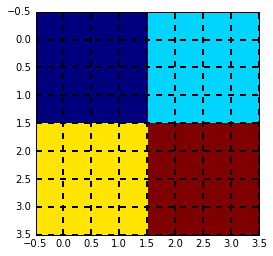

In [41]:
print "Target Image: (this is also the map from the target to the source)"
if HAS_PLT:
    ax = plt.imshow(target_image_data, interpolation='nearest')
    plt.grid(True, linestyle='--', linewidth=2)
print target_image_data

In [42]:
print "Map of the Source to the Target:"
print map_source_to_target_data
print ""

Map of the Source to the Target:
[[[[0 0 1 1]
   [0 1 0 1]]

  [[0 0 1 1]
   [2 3 2 3]]]


 [[[2 2 3 3]
   [0 1 0 1]]

  [[2 2 3 3]
   [2 3 2 3]]]]



When comparing the printed data to what is shown in the Section <a href='#Creating-Index-Map-Relationships'>Creating Index Map Relationships</a> we can see that we retrieved the correct data. Since we used our index map relationship, we did not even need to know names and locations of the datasets.

<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

#### Using Index Map Relationships to Load Data

We can now also use the relationship to directly load data. For the source we can usually directly load the data from the source. However, note, that the index map relationship may refer only to select axis of our dataset. If this is the case, then the `imr1['MAP_TO_SOURCE'].target_axis` as well as `imr1['SOURCE_TO_MAP'].axis` will be set to indicate which axes of the source the relationship applies to. 

For the target we can use the `MAP_TO_TARGET` relationship to translate selections from the `source` to the `target`. Similarly, if the relationship refers to only particular axes of the `target` then the `imr1['MAP_TO_TARGET'].target_axis` will be set. 

Let's see what happens when we load the first two pixels from the `source` and from the `target`.

In [43]:
source_selection = np.s_[1,1]
target_selection = imr1['MAP_TO_TARGET'][source_selection]
source_subimage = imr1_source[source_selection]  # We could also just write imr1_source[:,0]
target_subimage = imr1_target[:][target_selection[...,0,:] , target_selection[...,0,:] ] 

print "Data loaded from source:"
print source_subimage
print ""
print "Data loaded from target:"
print target_subimage
print ""
if np.all(target_subimage == source_subimage):
    print "SUCCESS: As we can see the values in the source pixel and the selected target pixels match as expected"
else: 
    print "ERROR: It looks like we have made some mistake."

Data loaded from source:
3

Data loaded from target:
[3 3 3 3]

SUCCESS: As we can see the values in the source pixel and the selected target pixels match as expected


Just to also show what we have done here visually, lets look at the maps of the elements we selected in source image---which shows that we selected the bottom-right pixel [1,1]---and the maps of the elements we selected in the target image---which shows that we selected the correspondign 4 pixel in the bottom-right corner of the target image.

Elements selected in the source image:


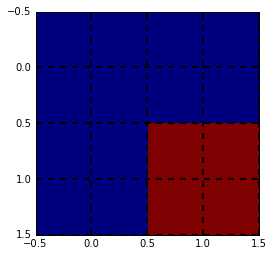

In [44]:
print "Elements selected in the source image:"
if HAS_PLT:
    source_selection_image = np.zeros(imr1_source.shape, dtype='bool')
    source_selection_image[source_selection] = True
    ax = plt.imshow(source_selection_image, interpolation='nearest')
    plt.grid(True, linestyle='--', linewidth=2)

Elements selected in the target image:


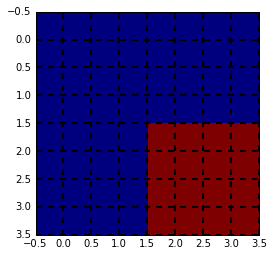

In [45]:
print "Elements selected in the target image:"
if HAS_PLT:
    target_selection_image = np.zeros(imr1_target.shape, dtype='bool')
    target_selection_image[target_selection[...,0,:], target_selection[...,1,:]] = True
    ax = plt.imshow(target_selection_image, interpolation='nearest')
    plt.grid(True, linestyle='--', linewidth=2)

Now when we loaded the data from the target image we used the following notation:

`target_subimage = imr1_target[:][target_selection[...,0,:] , target_selection[...,1,:] ] `

This notation is not arbitrary but we can deterimine programmatically based on the specification of the relationship how we need to define this selection:

**Why are doing `imr1_target[:]`?**: Again, we here load the full data of the target image first mainly because h5py.Dataset does not support the same fancy array-based indexing methods that numpy supports, i.e., this is just a quick workaround and we could also load the data one-element-at-a-time

**Why are we doing `[target_selection[...,0,:] , target_selection[...,1,:] ] `**: Our target dataset is two-dimensional---which we can check by looking at `imr1['MAP_TO_TARGET'].target.shape`. This means our indicies have multiple components and in numpy we need to describe the elements we select separately for each dimension of our data. Hence the two components: i) `target_selection[...,0,:]` and ii) `target_selection[...,1,:]`

**Ok, but how do we know we need to slice `target_selection[...,0,:]` in this particular order?** Here we need to look at the specification of the `axis` and `shape` of the relationship from our `map` to our `target`

In [46]:
print imr1['MAP_TO_TARGET'].source_axis    # These are the axis used for indexing
print imr1['MAP_TO_TARGET'].source.shape   # This is the shape of our map dataset

{u'INDEXING_AXIS': 2, u'STACK_AXIS': 3}
(2, 2, 2, 4)


as we can see:
1. `INDEXING_AXIS` is the second-to-last axis of our map dataset, i.e., this is the axis that stores the components of our mutlti-dimensional indicies. 
2. `STACK_AXIS` is the last axis of our map dataset, i.e., the set of elements that we map to are stored last. 

Hence, when we select the data in our target datsets, the first dimensions---which are describes by **...,** of our selection--- are the intrinsic dimensions of our map dataset. The **0** then is the dimension in our `target` dataset. And, finally **`:`** indicates that we want to select all elements that we map to (from our `STACK_AXIS`). Therefore, we write **`target_selection[...,0,:]`**.  

In the above example we selected just a single element `[1,1]` from our source data. As such the `target_selection[...,0,:]` addresses all data, because, `...`, collapes to nothing. However, if we select multiple elements from our source, then we will have to iterate over our intrinsic dimensions and load the mapped elements for each source element independently. An example for this is given below in the <a href='#Summary:-Interacting-with Index-Map-Relationships'>Summary</a> section below.

<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>

#### Summary: Interacting with Index Map Relationships

Since the above descriptions are heavly interlaced with validation code, below a quick summary of the main calls we used to interact with our index map relationship. 

To create our index map relationship we used the  `RelationshipAttribute.create_index_map_relationship(...)` function as follows:
```
mapping_relationships = RelationshipAttribute.create_index_map_relationship(
        name='upsampled_image_relationship',
        map_object=map_source_to_target,
        source_object=source_image,
        target_object=target_image,
        map_indexing_axis=2,  # i.e., the third dimension idenifies our indicies
        map_stack_axis=3)     # i.e., the fourth and last dimensions has the stack of pixels we relate to
```

In [47]:
# 1) Get all index map relationships
imr_names =  RelationshipAttribute.get_index_map_relationship_names(parent_object=source_image) 

In [48]:
# 2) Get specifically the relationships that desribe the 'upsampled_image_relationship' index map relationship
imr1 = RelationshipAttribute.get_index_map_relationship(parent_object=source_image,
                                                        relationship_name='upsampled_image_relationship')

In [49]:
# 3) Get the source, target and map dataset
imr1_source = imr1['MAP_TO_SOURCE'].target   
imr1_target = imr1['MAP_TO_TARGET'].target   
imr1_map = imr1['MAP_TO_SOURCE'].source

In [50]:
# 4) Load data from the source
# 4.1) Create the selection. We do this just for convenience but we could also just write [0:1,:] every time
source_selection = np.s_[0:1, :]   

# 4.2) If the relationship applies to the whole source dataset---i.e., 
#      `if imr1['SOURCE_TO_MAP'].source_axis is None` or alternatively 
#      `if imr1['MAP_TO_SOURCE'].target_axis is None---then we can 
#      simply slice agains the source directly.
selected_source_data1 = imr1_source[source_selection]   

# 4.3) If the index map relationship applies only to a subset of the source
#      dataset, then we need to look at imr1['SOURCE_TO_MAP'].source_axis
#      to identify to which axis in the source we can select from 

In [51]:
# 5) Load data from the target
# 5.1) Map the selection from the source to the target
target_selection = imr1['MAP_TO_TARGET'][source_selection] 

# 5.2) For each element we selected in the source dataset, load
#      the corresponding data values in the target dataset
selected_target_data = []
for i in range(target_selection.shape[0]):
    for j in range(target_selection.shape[1]):
        selected_target_data.append(imr1_target[:][target_selection[i,j,0,:] , target_selection[i,j,1,:]]) 

As we can see, our index map relationship allows us to programatically interact with both our source and target image dataset without having to know <i>a priori</i>: i) the name and location of our datasets (i.e., we need to know only the source or the map dataset), ii) the shapes of our datasets, iii) the ordering of elements in our map.  

## Other Relationship Chains

Currently `index map relationships` are the only kind of relationship chains with direct support by the BRAINformat API but users may, naturally, define their own semantics for other kinds of relationship chains (as long as they manage those chains).

<a href='#Brief-Introduction-to-Relationship-Attributes'>Top</a>